In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/ariel/github/ml-end-to-end-pipeline/data/raw/boston.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [25]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

Asi conoceremos cuales son las variables que afectan mas al precio, pero vayamos a ver la tambien visualmente:

In [26]:
df.corr()["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

### Correlation Heatmap  
We use a heatmap to visualize relationships between variables.  
RM and LSTAT show the strongest correlations with MEDV.

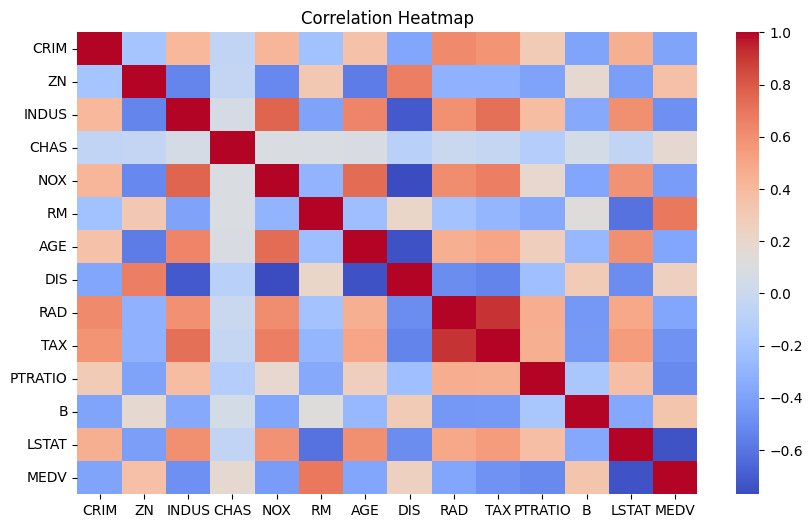

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [28]:
df.corr()["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

LET'S SEE HOW THIS CORRELATION WORKS:

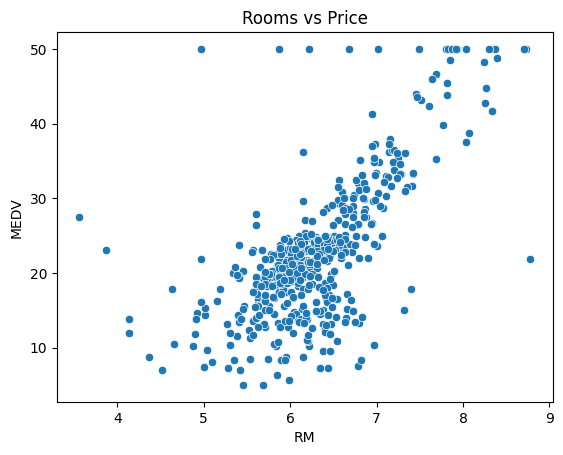

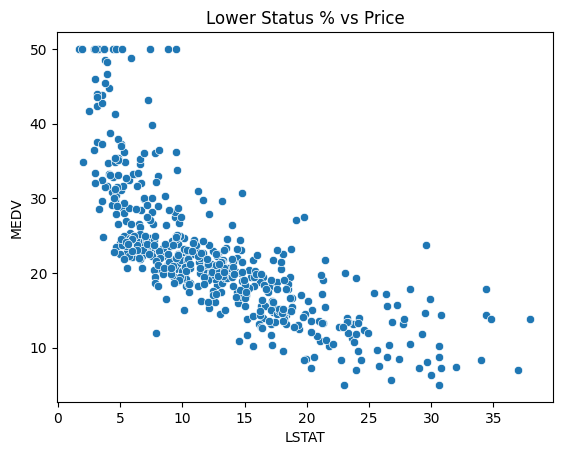

In [29]:

sns.scatterplot(x=df["RM"], y=df["MEDV"])
plt.title("Rooms vs Price")
plt.show()

sns.scatterplot(x=df["LSTAT"], y=df["MEDV"])
plt.title("Lower Status % vs Price")
plt.show()

### Relationship between Key Features and House Prices

To better understand the strongest correlations found in the dataset, we visualize how the two most influential variables relate to the target:

- **RM (average number of rooms)**: strong positive correlation with `MEDV`.  
  Houses with more rooms tend to have significantly higher prices.

- **LSTAT (% lower socio-economic status)**: strong negative correlation with `MEDV`.  
  Neighborhoods with a higher percentage of lower-status population show much lower home values.

The scatterplots below confirm these relationships clearly and justify why these features are crucial for the model's performance.

### Baseline model: Ridge Regression  
This first model gives us a reference performance before trying more advanced models.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X = df.drop("MEDV", axis=1)
y = df["MEDV"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = pipe.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds) ** 0.5

print('Error Medio:', mae)
print('Error global:', rmse)

Error Medio: 3.185723807244602
Error global: 4.930811680696358


### Improving the Model using GridSearchCV

After training the baseline model, we use GridSearchCV to search for the best hyperparameters and improve the model’s performance.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": [0.01, 0.1, 1, 5, 10, 20, 50, 100]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                
    scoring="neg_root_mean_squared_error",
    n_jobs=-1             
)

grid.fit(X_train, y_train)




,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [33]:
best_rmse = -grid.best_score_
print(grid.best_params_)
print(best_rmse)

{'model__alpha': 1}
4.828889026062195


In [34]:
best_model = grid.best_estimator_
preds = best_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds) ** 0.5

mae, rmse

(3.185723807244602, 4.930811680696358)

As we can see, the model achieves strong initial performance, with a MAE of 3.18 and a RMSE of 4.93.  
However, there is still room for improvement — so let's try to enhance the model and see how far we can go.

### Random Forest Regressor
Tree-based models capture non-linear relationships better than linear models.  
This model significantly outperformed the linear baseline.

In [35]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

pipe_rf.fit(X_train, y_train)

preds_rf = pipe_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, preds_rf)
rmse_rf = mean_squared_error(y_test, preds_rf) ** 0.5

mae_rf, rmse_rf

(2.0455980392156863, 2.8433047759639853)

### Tuning the Random Forest Model with GridSearchCV

To improve the performance of the Random Forest model, we use GridSearchCV to test different hyperparameter combinations.  
This process evaluates multiple model configurations using cross-validation and selects the one that gives the lowest RMSE.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

grid_rf.best_params_, -grid_rf.best_score_

({'model__max_depth': 10,
  'model__min_samples_split': 2,
  'model__n_estimators': 100},
 np.float64(4.010173626258274))

### Evaluating the Best Model on the Test Set

Once GridSearchCV selects the best hyperparameters, we evaluate that optimized model on the test set to measure its real performance.  
The value below shows the final RMSE obtained by the tuned Random Forest model.

In [37]:
best_rf = grid_rf.best_estimator_
preds_best = best_rf.predict(X_test)

rmse_best = mean_squared_error(y_test, preds_best) ** 0.5
rmse_best

2.8082110204628865

## 📈 Results

| Modelo                  | MAE  | RMSE |
|-------------------------|------|------|
| Linear Regression       | ~3.18 | ~4.93 |
| Ridge Regression (CV)   | ~3.15 | ~4.82 |
| Random Forest Regressor | **~2.04** | **~2.80** |

El **Random Forest** ofrece el mejor rendimiento y se selecciona como modelo final.

In [38]:
import joblib
joblib.dump(best_rf, "../models/random_forest_model.pkl")

['../models/random_forest_model.pkl']